In [1]:
# Import dependencies
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statistics import stdev
from math import sqrt
from scipy.stats import norm
import pickle, warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Read data

# All game scores historical through 2011
game_results_all = pd.read_csv('https://storage.googleapis.com/big-data-bowl/game-results-all.csv', encoding='latin')

# Offensive and defensive stats historical through 2011
season_stats_offense = pd.read_csv('https://storage.googleapis.com/big-data-bowl/season-stats-offense.csv', encoding='latin')
season_stats_defense = pd.read_csv('https://storage.googleapis.com/big-data-bowl/season-stats-defense.csv', encoding='latin')

# Kaggle games data
games = pd.read_csv('https://storage.googleapis.com/big-data-bowl/games.csv')

In [3]:
# Define team abbreviations
stats_team_abbr_dict = {
    'TB': 'Tampa Bay Buccaneers',
    'ATL': 'Atlanta Falcons',
    'BUF': 'Buffalo Bills',
    'CAR': 'Carolina Panthers',
    'CIN': 'Cincinnati Bengals',
    'DET': 'Detroit Lions',
    'HOU': 'Houston Texans',
    'IND': 'Indianapolis Colts',
    'TEN': 'Tennessee Titans',
    'WAS': 'Washington Redskins',
    'KC': 'Kansas City Chiefs',
    'NE': 'New England Patriots',
    'NO': 'New Orleans Saints',
    'NYG': 'New York Giants',
    'LA': 'Los Angeles Rams',
    'LV': 'Oakland Raiders',
    'CHI': 'Chicago Bears',
    'CLE': 'Cleveland Browns',
    'JAX': 'Jacksonville Jaguars',
    'MIA': 'Miami Dolphins',
    'NYJ': 'New York Jets',
    'PHI': 'Philadelphia Eagles',
    'PIT': 'Pittsburgh Steelers',
    'ARI': 'Arizona Cardinals',
    'LAC': 'Los Angeles Chargers',
    'SEA': 'Seattle Seahawks',
    'BAL': 'Baltimore Ravens',
    'GB': 'Green Bay Packers',
    'DEN': 'Denver Broncos',
    'MIN': 'Minnesota Vikings',
    'SF': 'San Francisco 49ers',
    'DAL': 'Dallas Cowboys'
}


In [4]:
# Merge offensive and defensive season stats
season_stats = season_stats_offense.merge(
    season_stats_defense,
    on='Team',
    suffixes=('_offensive', '_defensive')
)

# Create "Next Season" column for merging results data
season_stats['Next Season'] = season_stats['Season_offensive'] + 1
season_stats.drop(['Season_defensive', 'Season_offensive'], axis=1, inplace=True)
season_stats = season_stats.groupby(['Next Season', 'Team']).first().reset_index()

In [5]:
# Merge stats and scores for training data
training_data_all = game_results_all.merge(
    season_stats,
    left_on=['Home', 'Season'],
    right_on=['Team', 'Next Season']
)

training_data_all = training_data_all.merge(
    season_stats,
    left_on=['Visitor', 'Season'],
    right_on=['Team', 'Next Season'],
    suffixes=('_home', '_visitor')
)

training_data_all.drop(['Visitor', 'Home', 'Team_visitor', 'Team_home', 'Next Season_home', 'Next Season_visitor'], axis=1, inplace=True)
training_data_all['homeWin'] = training_data_all.apply(lambda row: int((row['Home Score'] - row['Visitor Score']) > 0), axis=1)
training_data_all.drop(columns=['Visitor Score', 'Home Score'], inplace=True)
training_data_all

,Season,Gms_offensive_home,Tot Pts_offensive_home,Pts/G_offensive_home,RushYds_offensive_home,RYds/G_offensive_home,PassYds_offensive_home,PYds/G_offensive_home,TotYds_offensive_home,Yds/G_offensive_home,...,Gms_defensive_visitor,Tot Pts_defensive_visitor,Pts/G_defensive_visitor,RushYds_defensive_visitor,RYds/G_defensive_visitor,PassYds_defensive_visitor,PYds/G_defensive_visitor,TotYds_defensive_visitor,Yds/G_defensive_visitor,homeWin
0,2021,16,492,30.8,1519,94.9,4626,289.1,6145,384.1,...,9,164,18.2,1288,143.1,1635,181.7,2923,324.8,1
1,2021,16,326,20.4,2346,146.6,2890,180.6,5236,327.2,...,9,164,18.2,1288,143.1,1635,181.7,2923,324.8,0
2,2021,16,384,24.0,1784,111.5,4329,270.6,6113,382.1,...,9,164,18.2,1288,143.1,1635,181.7,2923,324.8,0
3,2021,16,430,26.9,2283,142.7,4009,250.6,6292,393.2,...,9,164,18.2,1288,143.1,1635,181.7,2923,324.8,0
4,2021,16,492,30.8,1519,94.9,4626,289.1,6145,384.1,...,10,250,25.0,1194,119.4,2801,280.1,3995,399.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,2012,16,406,25.4,1864,116.5,4426,276.6,6290,393.1,...,9,149,16.6,1044,116.0,1570,174.4,2614,290.4,0
1167,2012,16,402,25.1,1834,114.6,4192,262.0,6026,376.6,...,9,149,16.6,1044,116.0,1570,174.4,2614,290.4,1
1168,2012,16,513,32.1,1764,110.2,5084,317.8,6848,428.0,...,9,176,19.6,998,110.9,1810,201.1,2808,312.0,1
1169,2012,16,329,20.6,1987,124.2,3091,193.2,5078,317.4,...,9,176,19.6,998,110.9,1810,201.1,2808,312.0,0


In [6]:
# Move 2021 data from training data to prediction data
training_data_raw = training_data_all.loc[training_data_all['Season'] < 2021]

In [7]:
# Clean home and visitor training sets for offense vs defense stats
home_training_data = training_data_raw[
    [c for c in training_data_raw.columns if \
     ('_offensive_home' in c) or \
     ('_defensive_visitor' in c) or \
     (c == 'homeWin')
    ]
]
home_training_data.loc[:, 'isHomeTeam'] = 1
home_training_data.drop([col for col in home_training_data.columns if ('_defensive_home' in col) or ('_offensive_visitor' in col)], inplace=True)
home_column_rename_dict = {col: col.replace('_home', '').replace('_visitor', '_opposing') for col in home_training_data.columns}
home_training_data = home_training_data.rename(columns=home_column_rename_dict)

visitor_training_data = training_data_raw[
    [c for c in training_data_raw.columns if \
     ('_offensive_visitor' in c) or \
     ('_defensive_home' in c) or \
     (c == 'homeWin')
    ]
]
visitor_training_data.loc[:, 'isHomeTeam'] = 0
visitor_training_data.drop([col for col in visitor_training_data.columns if ('_offensive_home' in col) or ('_defensive_visitor' in col)], inplace=True)
visitor_column_rename_dict = {col: col.replace('_visitor', '').replace('_home', '_opposing') for col in visitor_training_data.columns}
visitor_training_data = visitor_training_data.rename(columns=visitor_column_rename_dict)

In [8]:
# Combine home and visitor training sets
training_data = pd.concat([visitor_training_data, home_training_data], axis=0)

In [9]:
# Create home model
X = training_data.drop(['homeWin'], axis=1)
y = training_data['homeWin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
# Evaluate model accuracy
test_predictions = model.predict(X_test)
prediction_accuracy = test_predictions - y_test

In [11]:
# Prepare 2021 prediction input
matchups = games.copy()
games['homeTeam'] = games['homeTeamAbbr'].map(stats_team_abbr_dict)
games['visitorTeam'] = games['visitorTeamAbbr'].map(stats_team_abbr_dict)

matchups = games[['gameId', 'homeTeam', 'visitorTeam']]
matchups['Season'] = 2021

In [12]:
prediction_data_raw = matchups.merge(
    season_stats,
    left_on=['homeTeam', 'Season'],
    right_on=['Team', 'Next Season']
)

prediction_data_raw = prediction_data_raw.merge(
    season_stats,
    left_on=['visitorTeam', 'Season'],
    right_on=['Team', 'Next Season'],
    suffixes=('_home', '_visitor')
)

prediction_data_raw.drop(['Team_visitor', 'Team_home', 'Next Season_home', 'Next Season_visitor'], axis=1, inplace=True)

In [13]:
# Clean home and visitor prediction sets for offense vs defense stats
home_prediction_data = prediction_data_raw[
    [c for c in prediction_data_raw.columns if \
     ('_offensive_home' in c) or \
     ('_defensive_visitor' in c) or \
     (c in ['gameId', 'homeTeam', 'visitorTeam'])
    ]
]
home_prediction_data.loc[:, 'isHomeTeam'] = 1
home_prediction_data.drop([col for col in home_prediction_data.columns if ('_defensive_home' in col) or ('_offensive_visitor' in col)], inplace=True)
home_prediction_data = home_prediction_data.rename(columns=home_column_rename_dict)

visitor_prediction_data = prediction_data_raw[
    [c for c in prediction_data_raw.columns if \
     ('_offensive_visitor' in c) or \
     ('_defensive_home' in c) or \
     (c in ['gameId', 'homeTeam', 'visitorTeam'])
    ]
]
visitor_prediction_data.loc[:, 'isHomeTeam'] = 0
visitor_prediction_data.drop([col for col in visitor_training_data.columns if ('_offensive_home' in col) or ('_defensive_visitor' in col)], inplace=True)
visitor_prediction_data = visitor_prediction_data.rename(columns=visitor_column_rename_dict)

In [14]:
# Combine home and visitor prediction sets
prediction_data = pd.concat([visitor_prediction_data, home_prediction_data], axis=0)

In [15]:
# Make predictions
test_predictions = model.predict(prediction_data.drop(columns=['gameId', 'homeTeam', 'visitorTeam'], axis=1))
predicted_data = prediction_data[['gameId', 'homeTeam', 'visitorTeam']].copy()
predicted_data['predictedHomeWin'] = test_predictions

In [16]:
# Clean prediction results
prediction_results = predicted_data.merge(
    game_results_all[game_results_all['Season'] == 2021][['Home', 'Visitor', 'Home Score', 'Visitor Score']],
    left_on=['homeTeam', 'visitorTeam'],
    right_on=['Home', 'Visitor']
)

prediction_results.drop(columns=['homeTeam', 'visitorTeam'], inplace=True)
prediction_results['homeWin'] = prediction_results.apply(lambda row: int((row['Home Score'] - row['Visitor Score']) > 0), axis=1)
prediction_results['predictionCorrect'] = prediction_results.apply(lambda row: int(row['predictedHomeWin'] == row['homeWin']), axis=1)

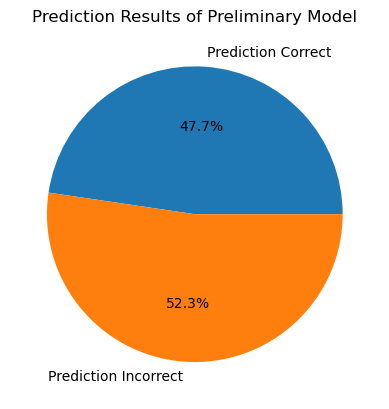

In [17]:
pie_data = [sum(prediction_results['predictionCorrect']), len(prediction_results['predictionCorrect']) - sum(prediction_results['predictionCorrect'])]
labels = ["Prediction Correct", "Prediction Incorrect"]
plt.pie(pie_data, labels=labels, autopct='%1.1f%%')
plt.title('Prediction Results of Preliminary Model')
plt.show()